In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR3 as p
from linearmodels.asset_pricing import LinearFactorModel
import statsmodels.api as sm

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:36: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:38: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)

In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


In [175]:
sector_portfolio_sorts={}
amihud_values={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s],amihud_values[s]=quantile_portfolios_annual_with_rank(sector_zscores[s],cleansed,5)

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  # This is added back by InteractiveShellApp.init_path()


# Acharya and Pedersen (2005) pricing levels of liquidity and liquidity risk
$$E_t(r_{t+1}^i- r_f) =  \alpha + E_t(c_{t+1}^i) + \lambda_t(\beta_t + \beta_t^{L1} - \beta_t^{L2} - \beta_t^{L3}) $$
where

* $c_t$:  Liquidity cost 
* $\beta_t^{L1}$:  Commonality in liquidity with the market, $cov(c^i,c^M)$
* $\beta_t^{L2}$:  Return sensitivity to market liquidity, $cov(r^i,c^M)$
* $\beta_t^{L3}$:  Liquidity sensitivity to market returns, $cov(c^i,r^M)$


In [256]:
sec='Equities'
bucket='4'
portfolio_rtn=sector_portfolio_sorts[sec][bucket]
portoflio_amihud=amihud_values[sec][bucket]
market=cleansed[sector_zscores[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
market_amihud=amihud[sector_zscores[sec].columns].median(axis=1)
factor=pd.DataFrame()
factor['Market']=market
factor['Factor1']=pd.expanding_corr(portfolio_amihud,market_amihud)
factor['Factor2']=pd.expanding_corr(portfolio_rtn,market_amihud)
factor['Factor3']=pd.expanding_corr(portfolio_amihud,market)
ind=portfolio_rtn['2001':].index
res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      4   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     309.4
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           2.89e-81
Time:                        07:44:49   Log-Likelihood:                 516.52
No. Observations:                 192   AIC:                            -1023.
Df Residuals:                     187   BIC:                            -1007.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0371      0.014     -2.746      0.0

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  if __name__ == '__main__':
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)


# Adding expected cost

In [217]:
sec='Fixed Income'
bucket='4'
portfolio_rtn=sector_portfolio_sorts[sec][bucket]
portoflio_amihud=amihud_values[sec][bucket]
market=cleansed[sector_zscores[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
market_amihud=amihud[sector_zscores[sec].columns].median(axis=1)
factor=pd.DataFrame()
factor['Market']=market
factor['E(c_t)']=portfolio_amihud
factor['Factor1']=pd.expanding_corr(portfolio_amihud,market_amihud)
factor['Factor2']=pd.expanding_corr(portfolio_rtn,market_amihud)
factor['Factor3']=pd.expanding_corr(portfolio_amihud,market)
ind=portfolio_rtn['2001':].index
res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      4   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     32.00
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           1.88e-23
Time:                        07:27:34   Log-Likelihood:                 647.48
No. Observations:                 192   AIC:                            -1283.
Df Residuals:                     186   BIC:                            -1263.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -0.838      0.4

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_pe

# Changing to innovations of liquidity

Using a first difference approach instead of an AR(2) residual

In [227]:
sec='Commodities'
bucket='2'
portfolio_rtn=sector_portfolio_sorts[sec][bucket]
portoflio_amihud=amihud_values[sec][bucket].diff()
market=cleansed[sector_zscores[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
market_amihud=amihud[sector_zscores[sec].columns].median(axis=1).diff()
factor=pd.DataFrame()
factor['Market']=market
factor['E(c_t)']=portfolio_amihud
factor['Factor1']=pd.expanding_corr(portfolio_amihud,market_amihud)
factor['Factor2']=pd.expanding_corr(portfolio_rtn,market_amihud)
factor['Factor3']=pd.expanding_corr(portfolio_amihud,market)
ind=portfolio_rtn['2001':].index
res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      2   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     51.56
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           2.32e-33
Time:                        07:32:23   Log-Likelihood:                 411.90
No. Observations:                 192   AIC:                            -811.8
Df Residuals:                     186   BIC:                            -792.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0071      0.009     -0.786      0.4

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_pe

# Changing to innovations of liquidity

Using AR(2) specification for calculating residuals

In [255]:
sec='Equities'
bucket='4'
portfolio_rtn=sector_portfolio_sorts[sec][bucket]
portoflio_amihud=calc_AR2_resid(amihud_values[sec][bucket])
market=cleansed[sector_zscores[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
market_amihud=calc_AR2_resid(amihud[sector_zscores[sec].columns].median(axis=1))
factor=pd.DataFrame()
factor['Market']=market
factor['E(c_t)']=portfolio_amihud
factor['Factor1']=pd.expanding_corr(portfolio_amihud,market_amihud)
factor['Factor2']=pd.expanding_corr(portfolio_rtn,market_amihud)
factor['Factor3']=pd.expanding_corr(portfolio_amihud,market)
ind=portfolio_rtn['2001':].index
res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      4   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     242.1
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           2.09e-79
Time:                        07:41:42   Log-Likelihood:                 515.12
No. Observations:                 192   AIC:                            -1018.
Df Residuals:                     186   BIC:                            -998.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0148      0.007     -2.076      0.0

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_pe

In [15]:
x=(sector_rtns['Equities'].median(axis=1)['2000':]+1).cumprod()

In [102]:
(amihud[d_map['Commodities']]*1e6*30).max().sort_values().tail()

TOCOM-PALLADIUM       36.602058
TOCOM-SILVER          48.061495
Rotterdam Coal        60.165597
Richards Bay Coal    106.587055
Milling Wheat        601.006925
dtype: float64

In [85]:
pro=(amihud[d_map['Equities']]*1e6*30)

In [100]:
pro['2000':].min().sort_values().head()

CME-MINI S&P 500 INDEX    4.148600e-07
Nasdaq                    3.426706e-06
KSE-KOSPI 200 INDEX       4.018871e-06
SGX DT-NIKKEI 225 ETS     4.162587e-06
EUREX-DJ EURO STOXX 50    4.356708e-06
dtype: float64

In [35]:
mkt='CME-NIKKEI 225 INDEX COMB.'

In [34]:
volume=load_daily_volume()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)

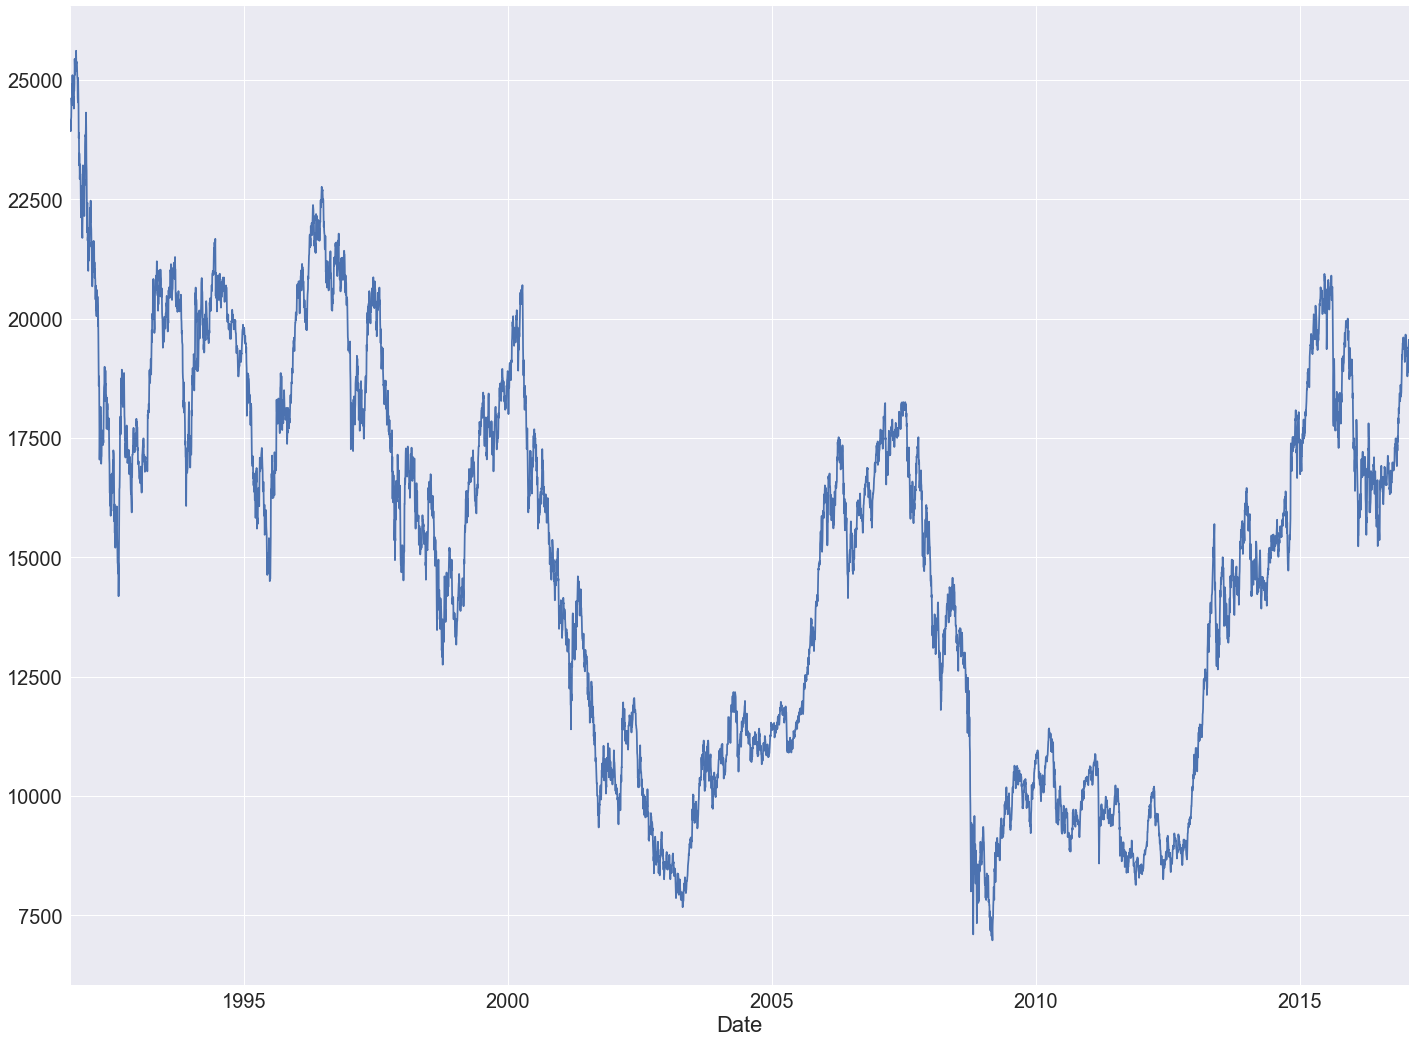

In [45]:
cleansed[mkt].dropna().plot()

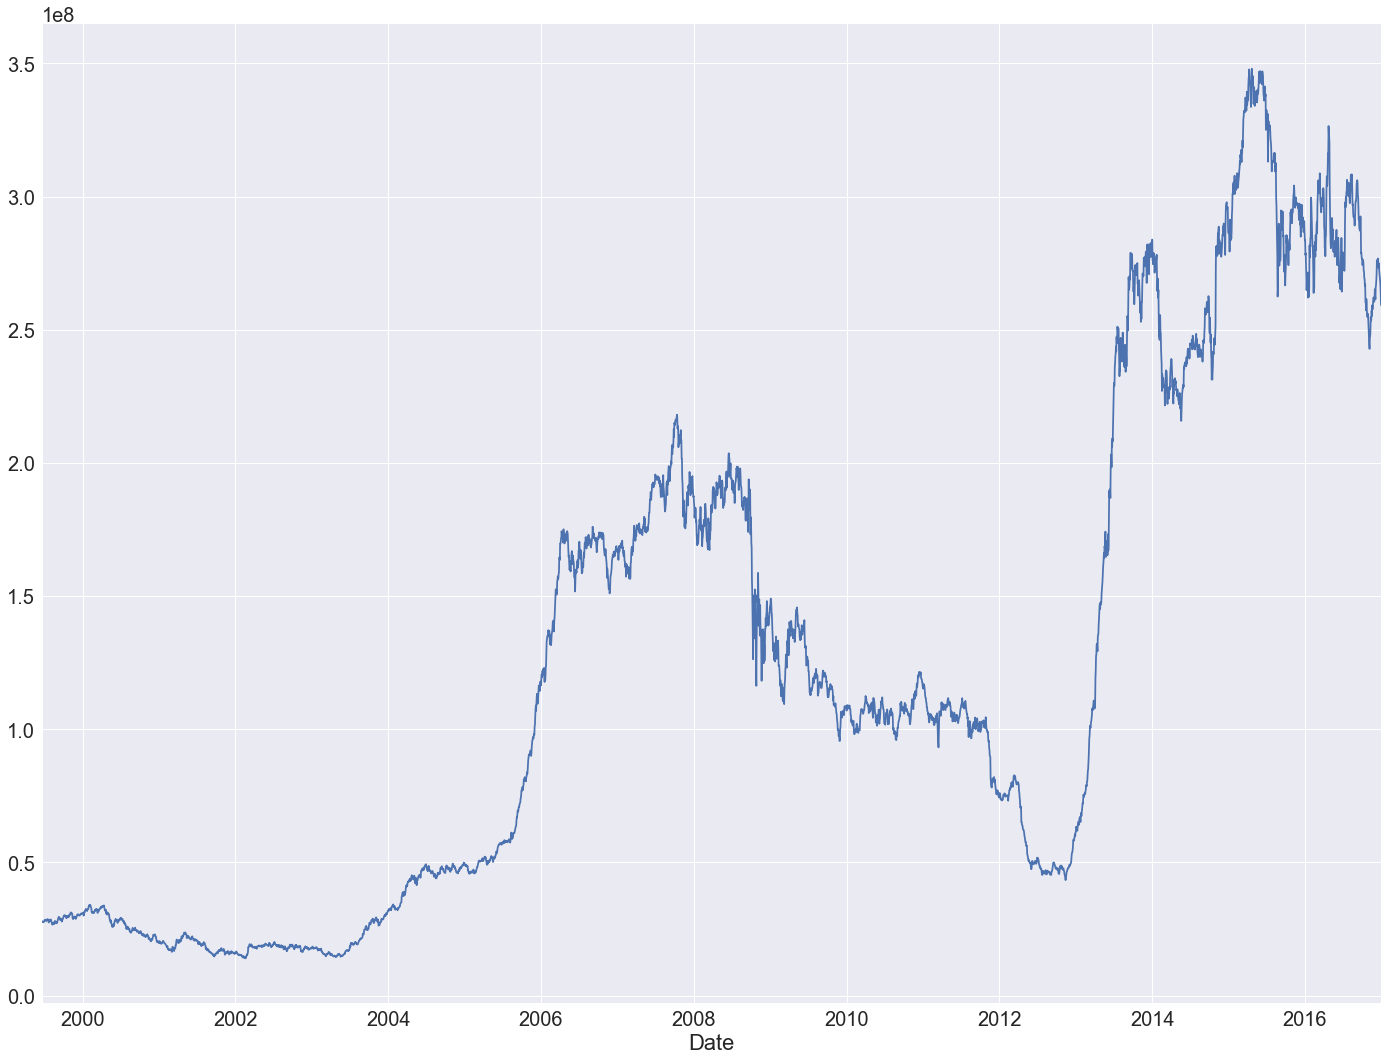

In [44]:
(cleansed[mkt]*volume[mkt]).dropna().plot()

In [52]:
contract_size=load_maps()
tick_map=contract_size.to_dict()['Tick Value']

In [53]:
tick_map[mkt]

5

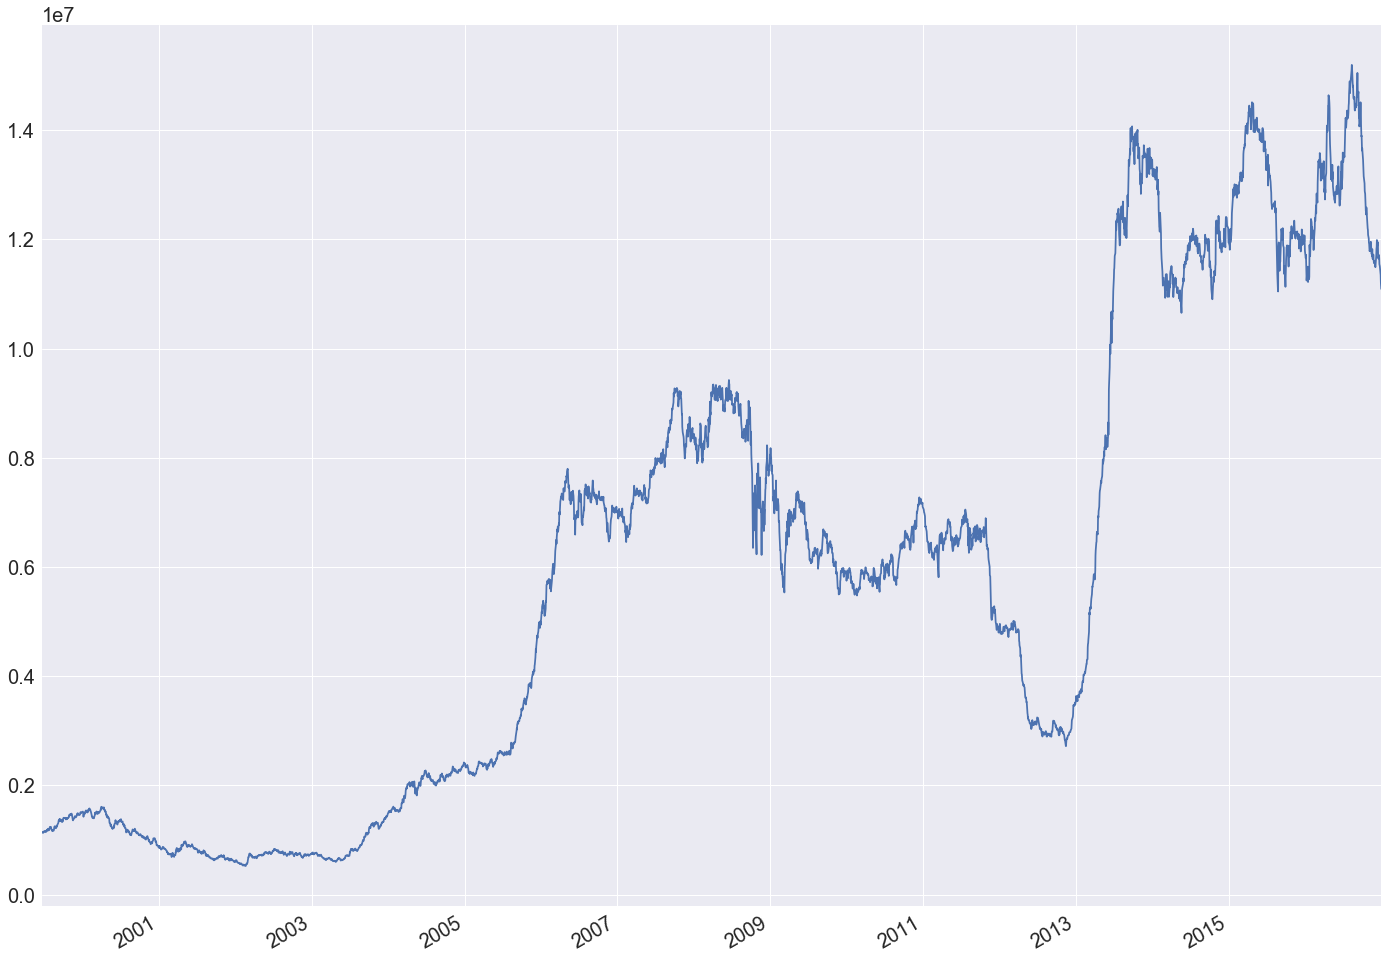

In [55]:
(cleansed[mkt]/fx['JPY']*volume[mkt]*5).dropna().plot()

In [21]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(labels=sector_zscores[sect].index,axis='index')
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print(sect)

In [107]:
sec='Equities'
ind=sector_PC[sec][0].index
mod=LinearFactorModel(sector_rtns[sec].loc[ind],sector_PC[sec][[0]])
res=mod.fit(cov_type='kernel')
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 28   R-squared:                      0.1047
No. Factors:                          1   J-statistic:                    427.92
No. Observations:                    53   P-value                         0.0000
Date:                  Sat, Mar 17 2018   Distribution:                 chi2(27)
Time:                          13:04:57                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
0              0.4365     0.4560     0.9574     0.3384     -0.4572      1.3302

Covariance estimator:
KernelCovaria

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [95]:
from linearmodels.asset_pricing import LinearFactorModelGMM
mod=LinearFactorModelGMM(sector_rtns[sec].loc[ind],sector_PC[sec][0])

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [96]:
res = mod.fit(cov_type='kernel', kernel='bartlett', disp=0)
print(res)

                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                 28   R-squared:                  -3.287e+15
No. Factors:                          1   J-statistic:                -4.841e+28
No. Observations:                    53   P-value                         1.0000
Date:                  Sat, Mar 17 2018   Distribution:                 chi2(27)
Time:                          13:01:20                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor      1.524e+06                              nan                        

Covariance estimator:
KernelCovaria

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/asset_pricing/results.py:243: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(self._rp_cov))


In [97]:
res = mod.fit(steps=10, disp=25)
print(res)

Iteration: 0, Objective: -2.7861419212967964e+26
         Current function value: -278614192129679638363373568.000000
         Iterations: 1
         Function evaluations: 1548
         Gradient evaluations: 48
Iteration: 0, Objective: 1773566356819186.8
         Current function value: -9421424018869047296.000000
         Iterations: 7
         Function evaluations: 972
         Gradient evaluations: 30
Iteration: 0, Objective: 2.4008558778988687e+18
Optimization terminated successfully.
         Current function value: -76678491142448532941761402751743903491877425381376.000000
         Iterations: 4
         Function evaluations: 736
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 66444278294411144449946956918161408.000000
         Iterations: 0
         Function evaluations: 32
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 66444278294411144449946956918161408.000000
    

In [98]:
print(res.full_summary)

                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                 28   R-squared:                      -8e+21
No. Factors:                          1   J-statistic:                 6.644e+34
No. Observations:                    53   P-value                         0.0000
Date:                  Sat, Mar 17 2018   Distribution:                 chi2(27)
Time:                          13:01:22                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor     -1.351e+08     0.0689  -1.96e+09     0.0000  -1.351e+08  -1.351e+08


                          AEX-AEX 

# FHT method

In [143]:
FHT=calculate_FHT(cleansed)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:53: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:54: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(

In [146]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')
sector_PC_FHT={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(labels=sector_zscores[sect].index,axis='index')
            pcs[i]=x
        sector_PC_FHT[sect] = pcs
    except:
        print(sect)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


# Presentation
First rsquares of residuals

In [127]:
FF=pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0).resample(rule='m',how='sum')/100.

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [130]:
FF.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')

In [147]:
temp=pd.DataFrame()
temp=sector_PC_FHT[sec][[0]]
temp['Mkt-RF']=FF['Mkt-RF']

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
sec='Fixed Income'
ind=sector_PC[sec][0].index
mod=LinearFactorModel(sector_rtns[sec].loc[ind],temp)
res=mod.fit(cov_type='kernel')
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 26   R-squared:                      0.1178
No. Factors:                          2   J-statistic:                    235.81
No. Observations:                    46   P-value                         0.0000
Date:                  Sun, Mar 18 2018   Distribution:                 chi2(24)
Time:                          16:11:04                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
0              0.2476     1.0627     0.2330     0.8157     -1.8352      2.3305
Mkt-RF         0.0021     0.0107    

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


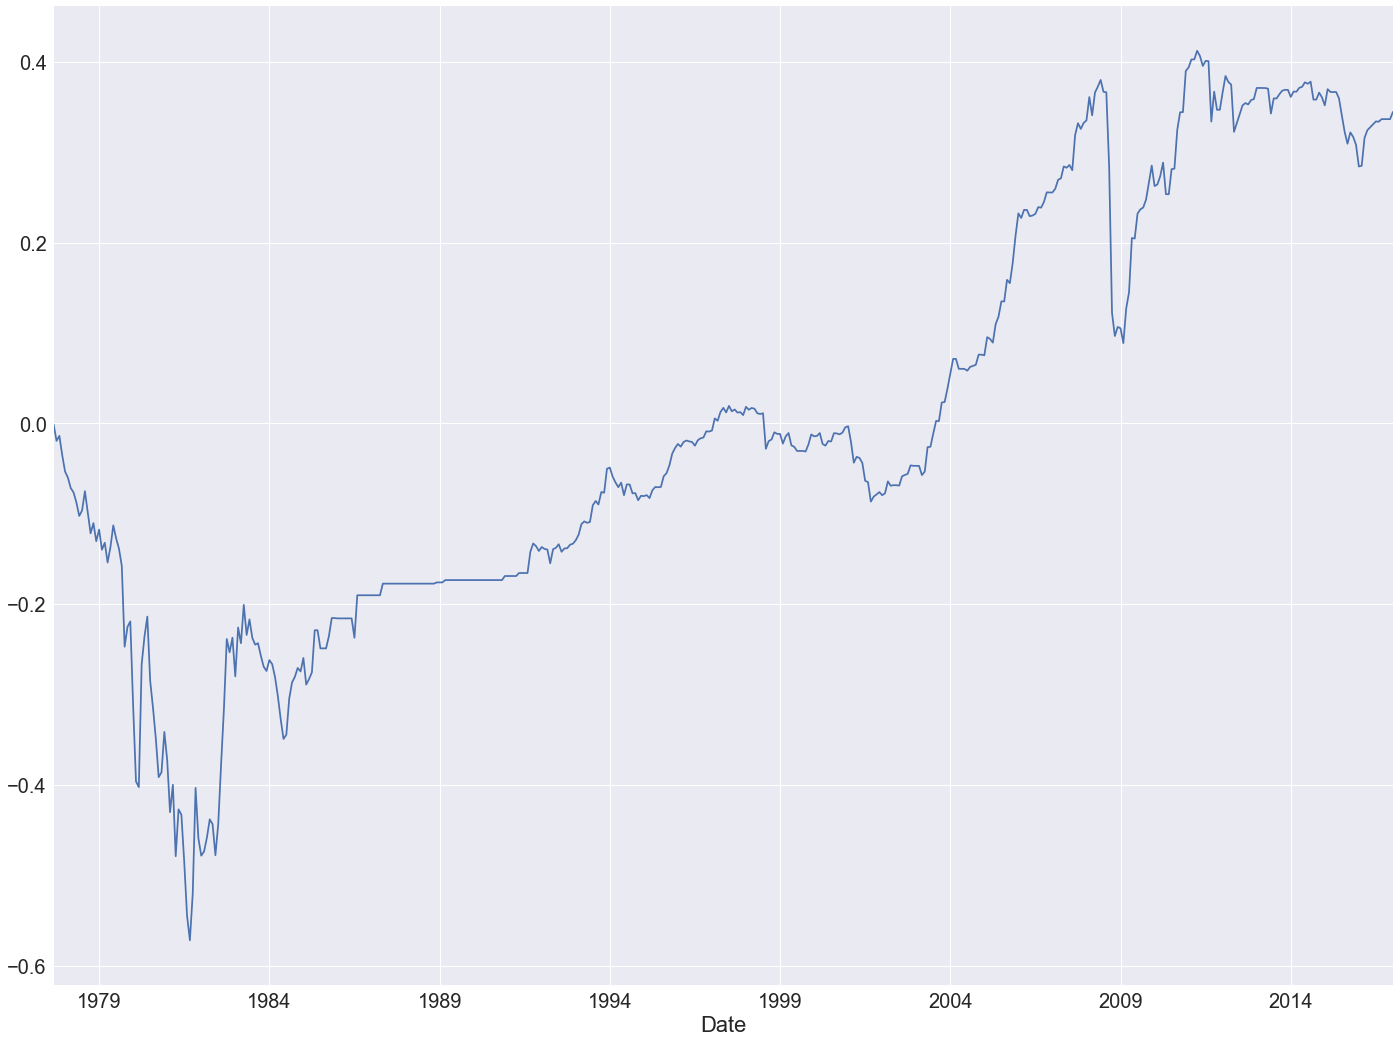

In [159]:
cleansed.resample(rule='m',how='last').pct_change().median(axis=1).cumsum().dropna().plot()

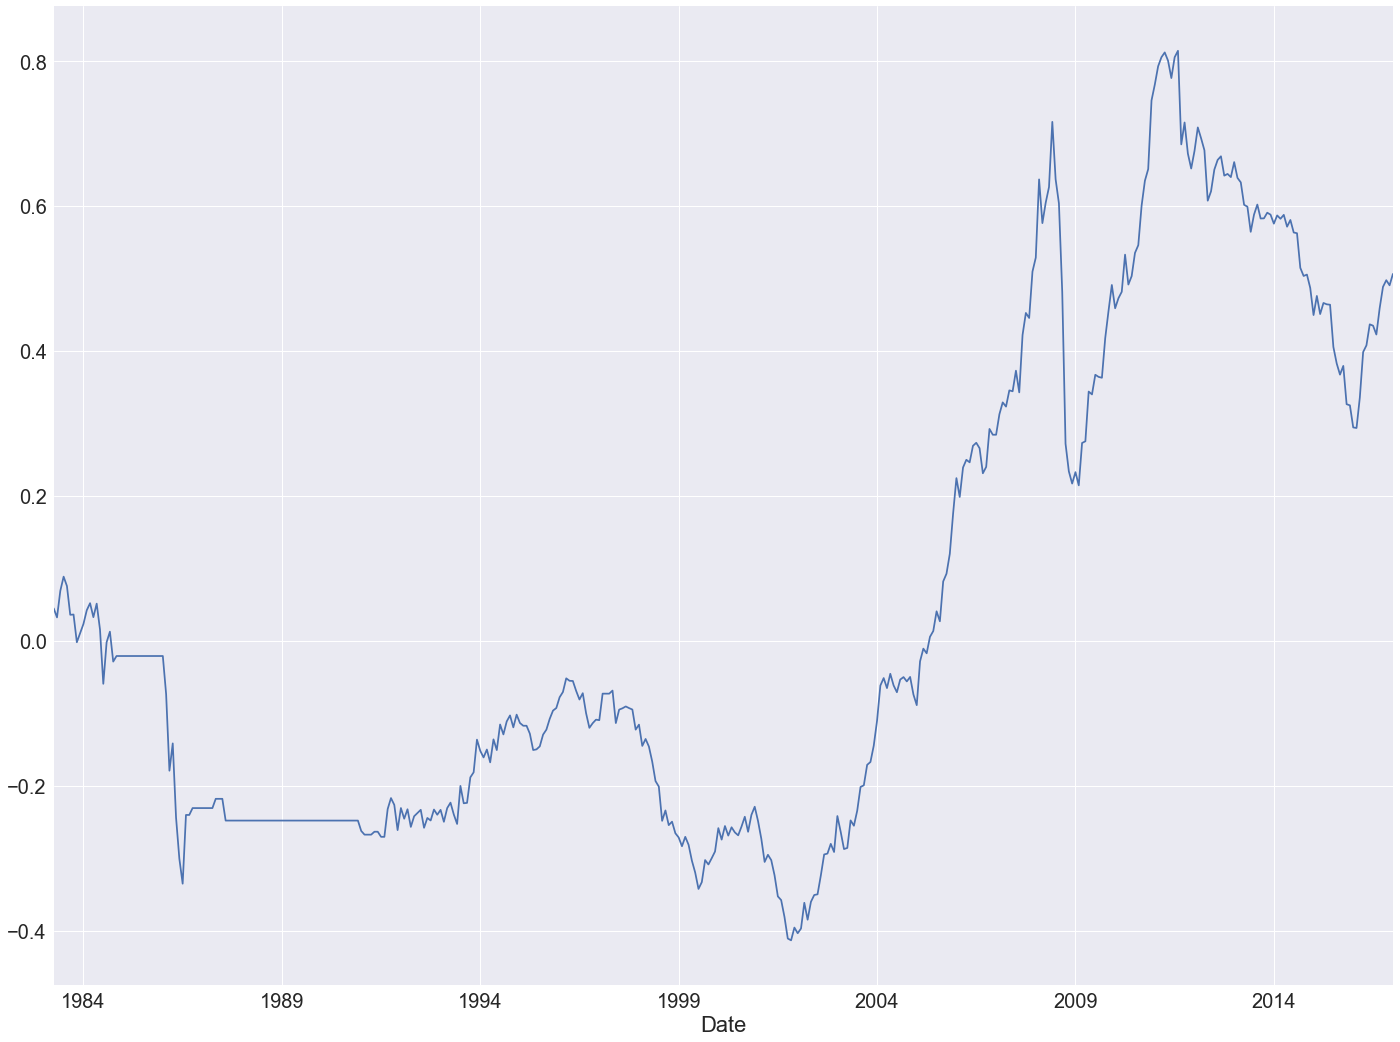

In [163]:
sector_rtns['Commodities'].median(axis=1).cumsum().plot()